# Bagging rankers demo

This notebook produces loads of graphs...

Tests different aggregation methods under different combinations of number of rankers and data proportion split

Builds on the rank aggregation idea, and incorporates splitting of data for each base ranker, but uses homogenous rankers.

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from rankers.Bagger import Bagger
import pandas as pd
from Evaluations import get_evaluation_plots

In [2]:
save_path = "../../../Data/bagger_temp/"

In [3]:
#loading test and trainig data
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


In [4]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

for LGBM ranker, when splitting data for bagger, need to recompute the train baskets based on the subset - just regroup the data in the same way as in PrepareData

In [5]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=0
)

In [6]:
#testing varying number of rankers, proportion of samples each ranker is trained on, and aggregation methods
nr_rankers_range = [1, 4, 8]
samples_proportion_range = [0.33, 0.66, 1]
aggregation_methods = ["interleaf", "sum", "prod"]

In [7]:
#training new bagger for each combination of nr_rankers and samples_proportion and recording results
#NB this code (and the bagger class) could be optimised so that base rankers can be reused rather than retrained
for agg in aggregation_methods:
    print(f"Testing with {agg} aggregation")
    for nr in nr_rankers_range:
        cols_to_save = []
        print(f"  Testing with {nr} rankers")
        for sp in samples_proportion_range:
            print(f"    Testing with {sp} of training data for each ranker.")

            bagger = Bagger(lgbm_ranker, nr, sp)
            bagger = bagger.fit(train, columns_to_use, use_groups=True)
            pred_name = f"{agg}-{nr}Rankers-{sp}Prop"
            cols_to_save.append(pred_name)
            test[pred_name] = bagger.predict(test, columns_to_use, aggregation=agg)

        #saving predictions from this nr, agg combination and deleting columns (to save memory so it can run on my little laptop)
        test[cols_to_save].to_parquet(f"{save_path}{agg}{nr}.parquet")
        test.drop(cols_to_save + [f"ranker{i}" for i in range(nr)], axis=1, inplace=True)       #also drop "ranker{n}" for n in range(nr_rankers_range)

        


Testing with interleaf aggregation
  Testing with 1 rankers
    Testing with 0.33 of training data for each ranker.
    Testing with 0.66 of training data for each ranker.
    Testing with 1 of training data for each ranker.
  Testing with 4 rankers
    Testing with 0.33 of training data for each ranker.
    Testing with 0.66 of training data for each ranker.
    Testing with 1 of training data for each ranker.
  Testing with 8 rankers
    Testing with 0.33 of training data for each ranker.
    Testing with 0.66 of training data for each ranker.
    Testing with 1 of training data for each ranker.
Testing with sum aggregation
  Testing with 1 rankers
    Testing with 0.33 of training data for each ranker.
    Testing with 0.66 of training data for each ranker.
    Testing with 1 of training data for each ranker.
  Testing with 4 rankers
    Testing with 0.33 of training data for each ranker.
    Testing with 0.66 of training data for each ranker.
    Testing with 1 of training data for

In [8]:
#removing redundant data from test frame, and adding predictions back (again, necessary to run on my machine)
test = test[["article_id", "customer_id", "purchased"]]
for agg in aggregation_methods:
    for nr in nr_rankers_range:
        test = pd.concat([test, pd.read_parquet(f"{save_path}{agg}{nr}.parquet")], axis=1)

In [9]:
#sanity check - each ranker gives rankings
test.head()

,article_id,customer_id,purchased,interleaf-1Rankers-0.33Prop,interleaf-1Rankers-0.66Prop,interleaf-1Rankers-1Prop,interleaf-4Rankers-0.33Prop,interleaf-4Rankers-0.66Prop,interleaf-4Rankers-1Prop,interleaf-8Rankers-0.33Prop,...,sum-8Rankers-1Prop,prod-1Rankers-0.33Prop,prod-1Rankers-0.66Prop,prod-1Rankers-1Prop,prod-4Rankers-0.33Prop,prod-4Rankers-0.66Prop,prod-4Rankers-1Prop,prod-8Rankers-0.33Prop,prod-8Rankers-0.66Prop,prod-8Rankers-1Prop
11557594,925246001,28847241659200,0.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,...,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
11557595,909370001,28847241659200,0.0,3.0,6.5,6.5,10.0,9.0,10.0,8.0,...,3.0,6.5,6.5,3.0,3.0,3.0,3.0,3.0,3.0,3.0
11557596,865799006,28847241659200,0.0,7.0,6.5,6.5,9.0,10.0,9.0,9.0,...,8.5,6.5,6.5,7.0,4.5,8.5,8.5,8.0,8.5,8.5
11557597,918522001,28847241659200,0.0,12.0,11.5,12.0,12.0,12.0,12.0,12.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
11557598,924243001,28847241659200,0.0,1.5,1.5,1.5,2.0,2.0,2.0,2.0,...,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5


Graphs for 1 rankers
  Graphs for 0.33 sample proportion
Evaluation for interleaf-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011330430692613111
MAP@12 (only purchasing customers): 0.022534391020600907

MRR (all customers):                0.002162914050951781
MRR (only purchasing customers):    0.04301685636705359



Evaluation for sum-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011490361246794824
MAP@12 (only purchasing customers): 0.022852466982746084

MRR (all customers):                0.00219258635842697
MRR (only purchasing customers):    0.043606990491050594



Evaluation for prod-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011603764772451463
MAP@12 (only purchasing customers): 0.023078008222932784

MRR (all customers):                0.002195094293630723
MRR (only purchasing customers):    0.04365686925918299





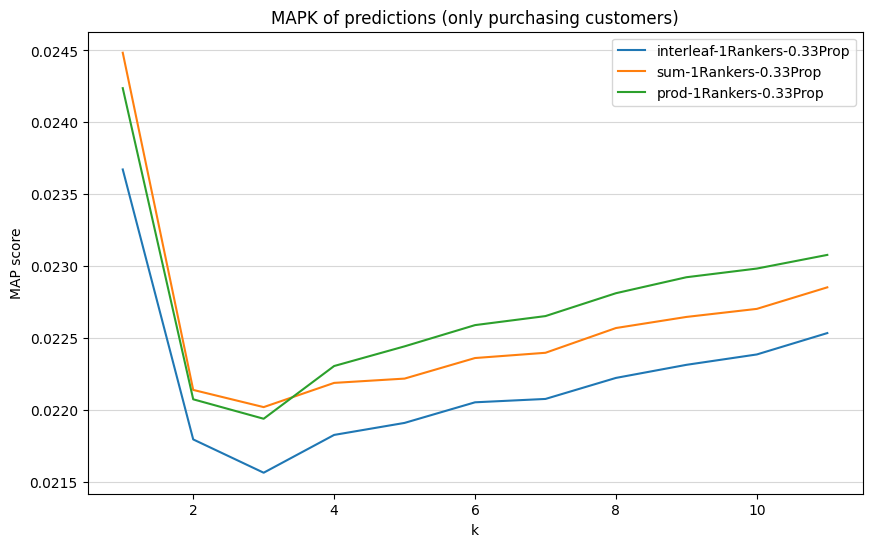

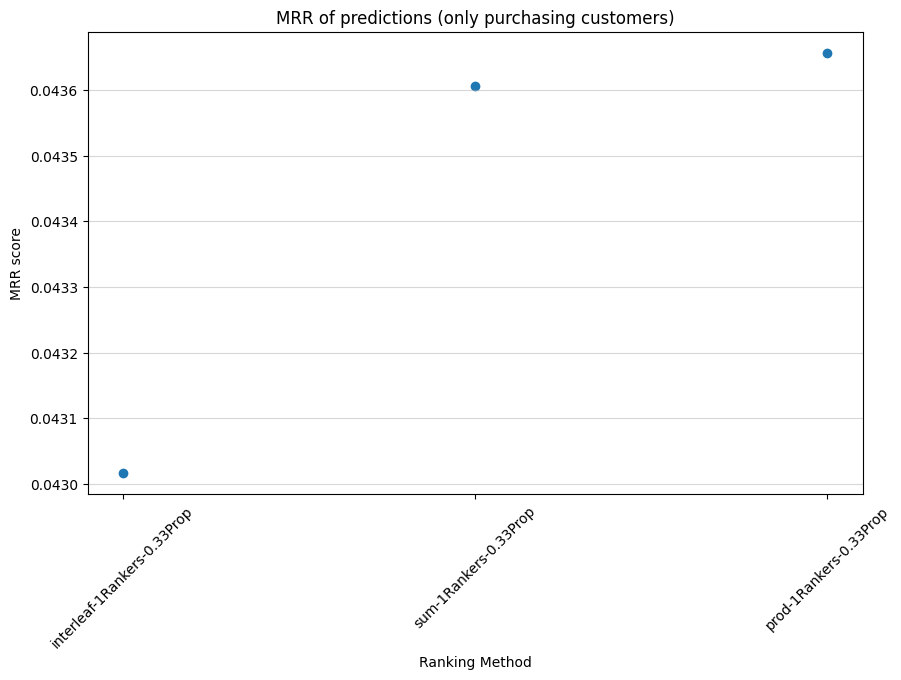

  Graphs for 0.66 sample proportion
Evaluation for interleaf-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011755672118718898
MAP@12 (only purchasing customers): 0.02338012732436499

MRR (all customers):                0.0022335886010648107
MRR (only purchasing customers):    0.044422458669965484



Evaluation for sum-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.001169763589871583
MAP@12 (only purchasing customers): 0.023264702685144596

MRR (all customers):                0.002211468128755561
MRR (only purchasing customers):    0.043982518312797966



Evaluation for prod-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011711336496210735
MAP@12 (only purchasing customers): 0.023291950953947586

MRR (all customers):                0.002225236714059447
MRR (only purchasing customers):    0.04425635316820249





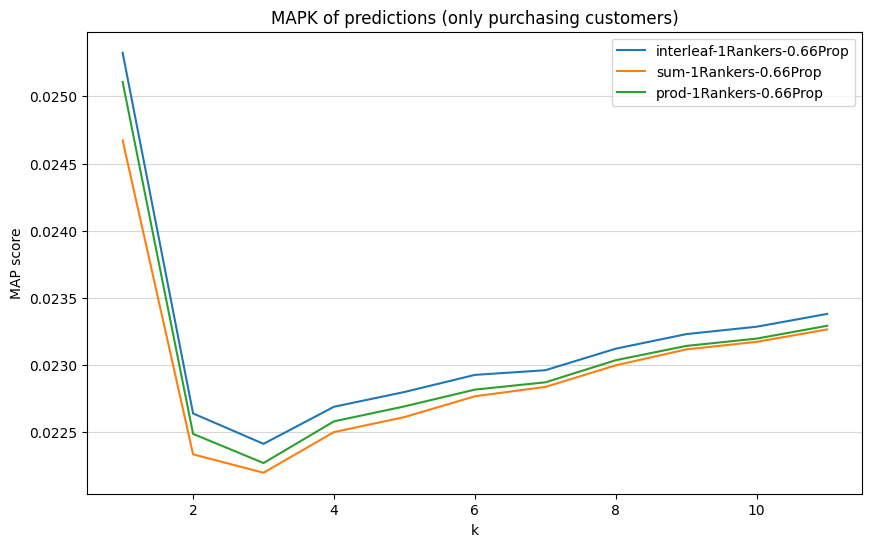

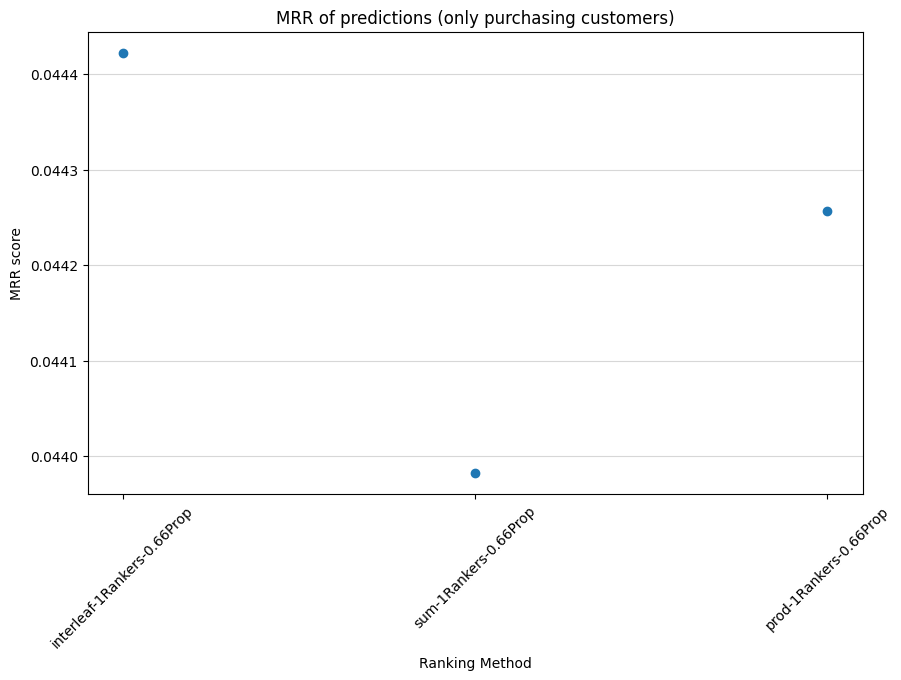

  Graphs for 1 sample proportion
Evaluation for interleaf-1Rankers-1Prop
####################

MAP@12 (all customers):             0.00116729104668646
MAP@12 (only purchasing customers): 0.023215527806924638

MRR (all customers):                0.0022128578004210345
MRR (only purchasing customers):    0.04401015663083687



Evaluation for sum-1Rankers-1Prop
####################

MAP@12 (all customers):             0.0011720128154390473
MAP@12 (only purchasing customers): 0.023309436137743018

MRR (all customers):                0.0022187016996343778
MRR (only purchasing customers):    0.04412638231857204



Evaluation for prod-1Rankers-1Prop
####################

MAP@12 (all customers):             0.0011568086344114668
MAP@12 (only purchasing customers): 0.023007049609182477

MRR (all customers):                0.002201537515208272
MRR (only purchasing customers):    0.043785014497788544





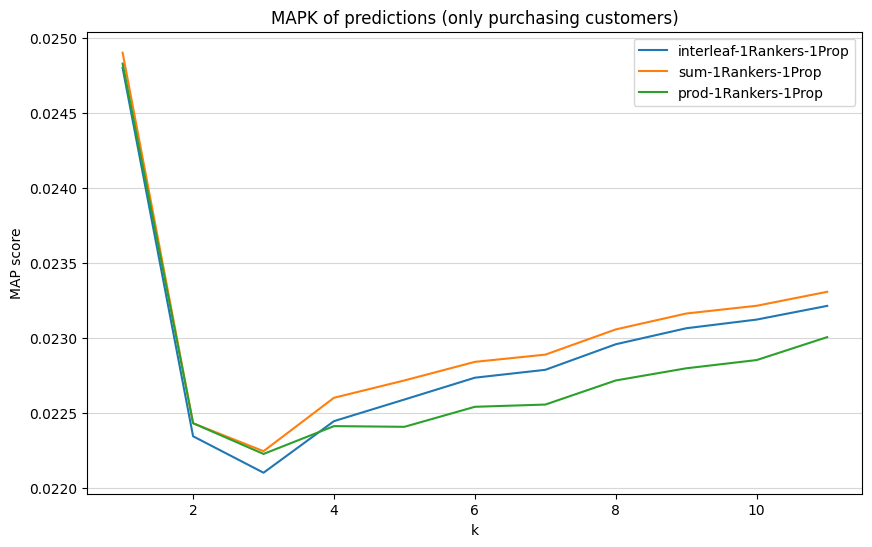

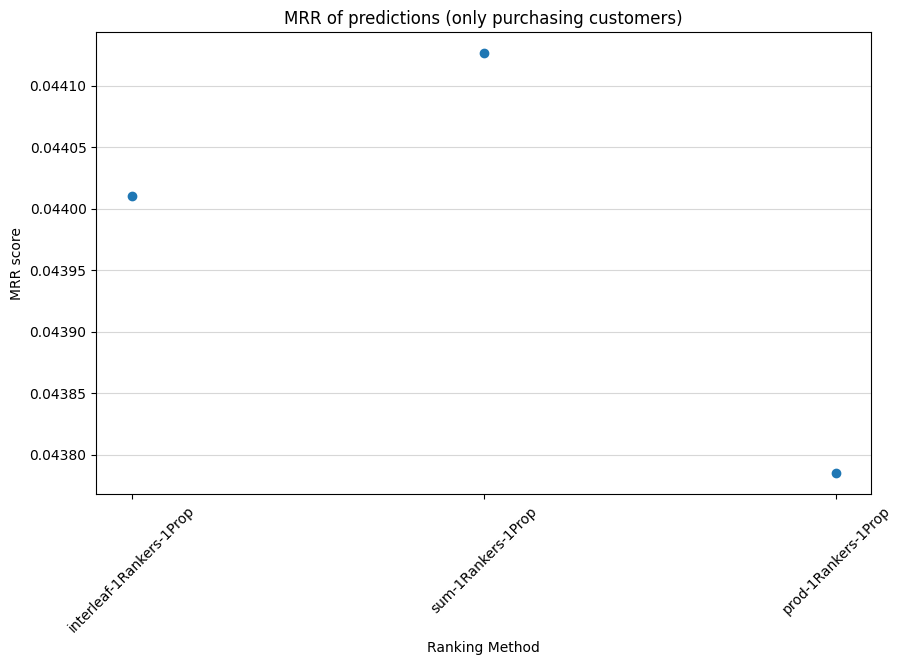

Graphs for 4 rankers
  Graphs for 0.33 sample proportion
Evaluation for interleaf-4Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011631814054443887
MAP@12 (only purchasing customers): 0.023133793700591324

MRR (all customers):                0.0022037744104027933
MRR (only purchasing customers):    0.0438295027192454



Evaluation for sum-4Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011521225087362797
MAP@12 (only purchasing customers): 0.022913850161428755

MRR (all customers):                0.0021994902007730203
MRR (only purchasing customers):    0.04374429673049647



Evaluation for prod-4Rankers-0.33Prop
####################

MAP@12 (all customers):             0.001148598448373199
MAP@12 (only purchasing customers): 0.022843762310087286

MRR (all customers):                0.0021956849915165705
MRR (only purchasing customers):    0.04366861728315123





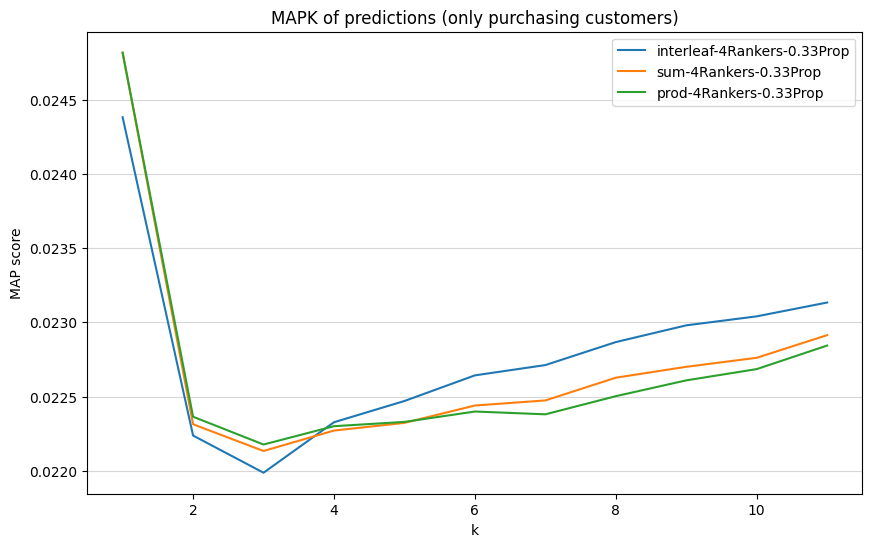

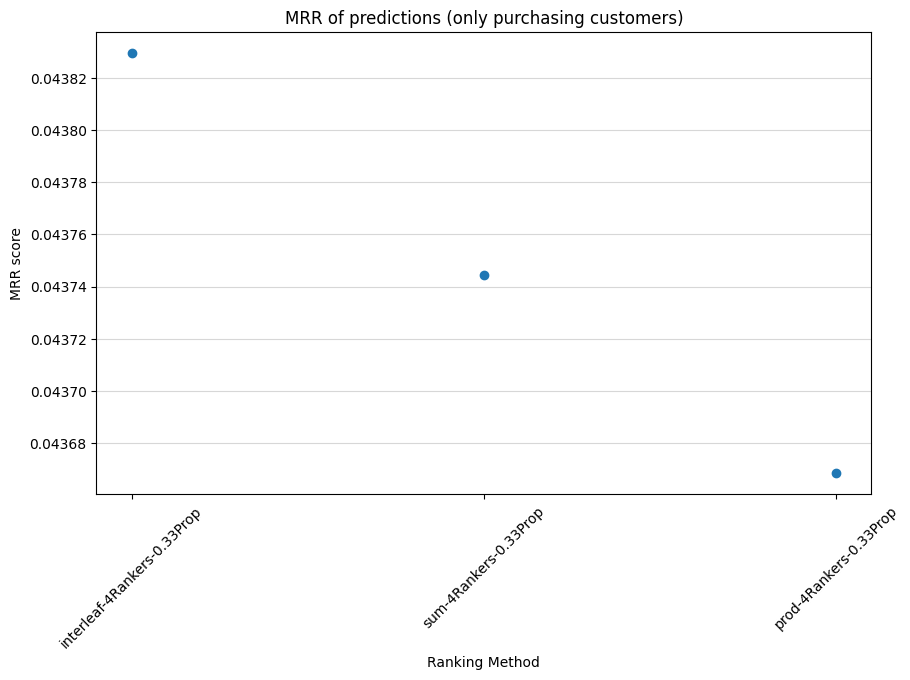

  Graphs for 0.66 sample proportion
Evaluation for interleaf-4Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011636801331661075
MAP@12 (only purchasing customers): 0.023143712586994623

MRR (all customers):                0.0022100618128986006
MRR (only purchasing customers):    0.04395454896875539



Evaluation for sum-4Rankers-0.66Prop
####################

MAP@12 (all customers):             0.001148943737687762
MAP@12 (only purchasing customers): 0.022850629555155634

MRR (all customers):                0.0021978188662652018
MRR (only purchasing customers):    0.043711056594841285



Evaluation for prod-4Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011509560441278564
MAP@12 (only purchasing customers): 0.02289065107013999

MRR (all customers):                0.002200291409554667
MRR (only purchasing customers):    0.04376023147513644





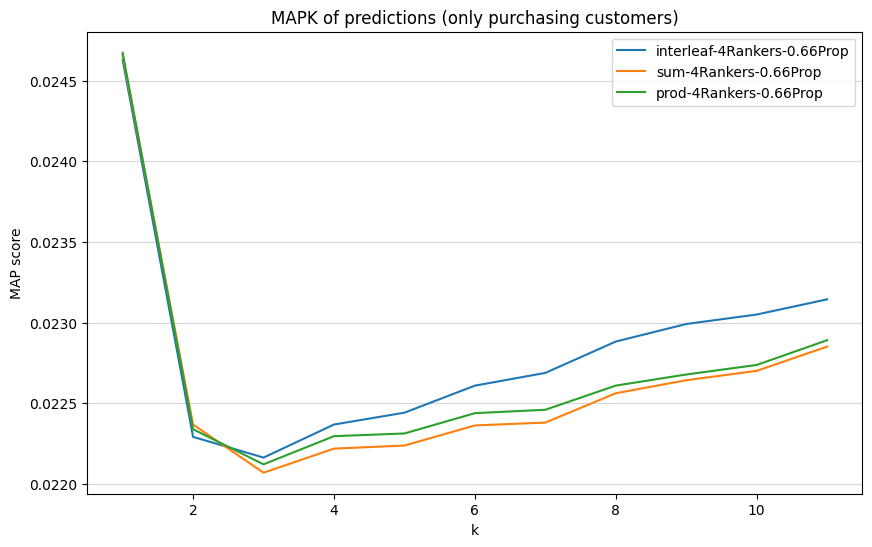

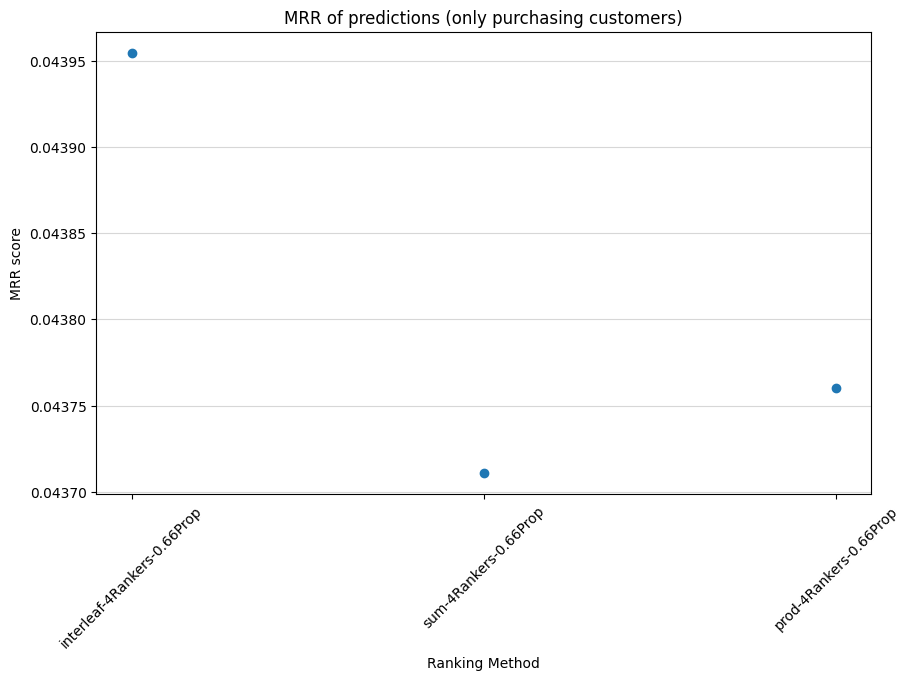

  Graphs for 1 sample proportion
Evaluation for interleaf-4Rankers-1Prop
####################

MAP@12 (all customers):             0.0011685633039998176
MAP@12 (only purchasing customers): 0.023240830943721286

MRR (all customers):                0.0022222613216104515
MRR (only purchasing customers):    0.04419717743278307



Evaluation for sum-4Rankers-1Prop
####################

MAP@12 (all customers):             0.0011571652518254975
MAP@12 (only purchasing customers): 0.023014142151796743

MRR (all customers):                0.0022090195657230196
MRR (only purchasing customers):    0.04393382036096295



Evaluation for prod-4Rankers-1Prop
####################

MAP@12 (all customers):             0.0011549213459716623
MAP@12 (only purchasing customers): 0.02296951449968401

MRR (all customers):                0.002206307193570129
MRR (only purchasing customers):    0.04387987567311761





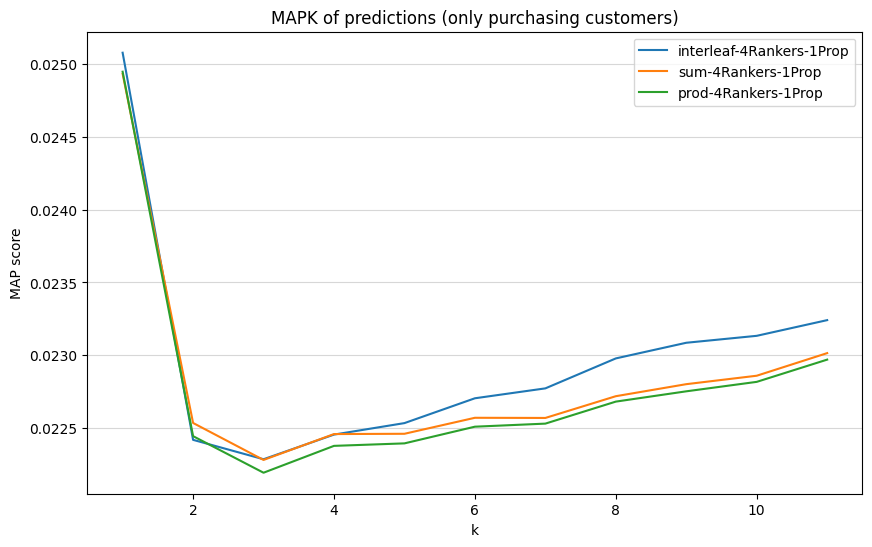

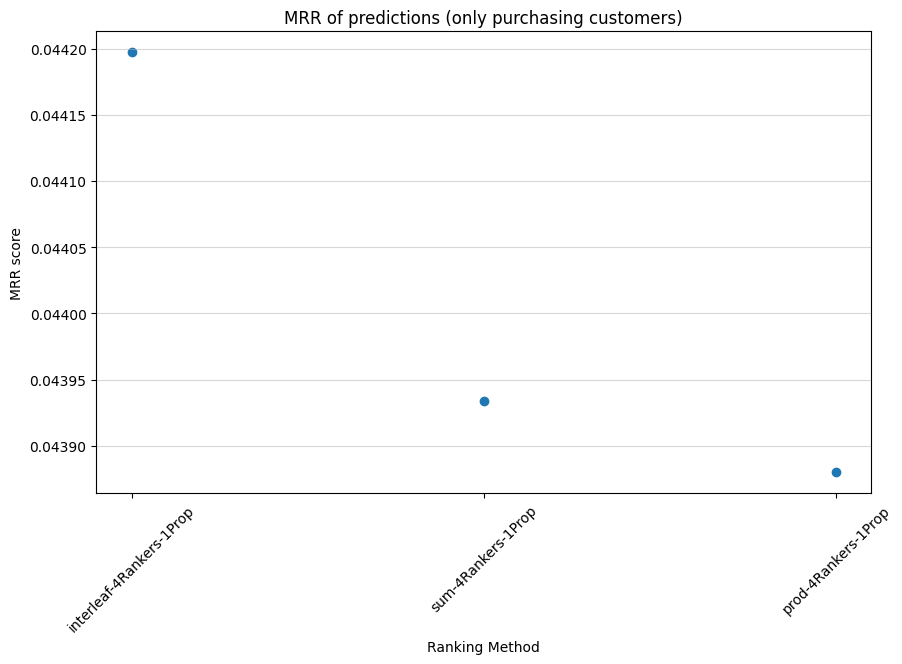

Graphs for 8 rankers
  Graphs for 0.33 sample proportion
Evaluation for interleaf-8Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011593699114062772
MAP@12 (only purchasing customers): 0.023057989259120722

MRR (all customers):                0.002201690363052059
MRR (only purchasing customers):    0.043788054393774846



Evaluation for sum-8Rankers-0.33Prop
####################

MAP@12 (all customers):             0.00115397168061867
MAP@12 (only purchasing customers): 0.022950627194352362

MRR (all customers):                0.002206622276266152
MRR (only purchasing customers):    0.043886142157480504



Evaluation for prod-8Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011542960912286893
MAP@12 (only purchasing customers): 0.022957079195812625

MRR (all customers):                0.0022019062379526936
MRR (only purchasing customers):    0.043792347795812606





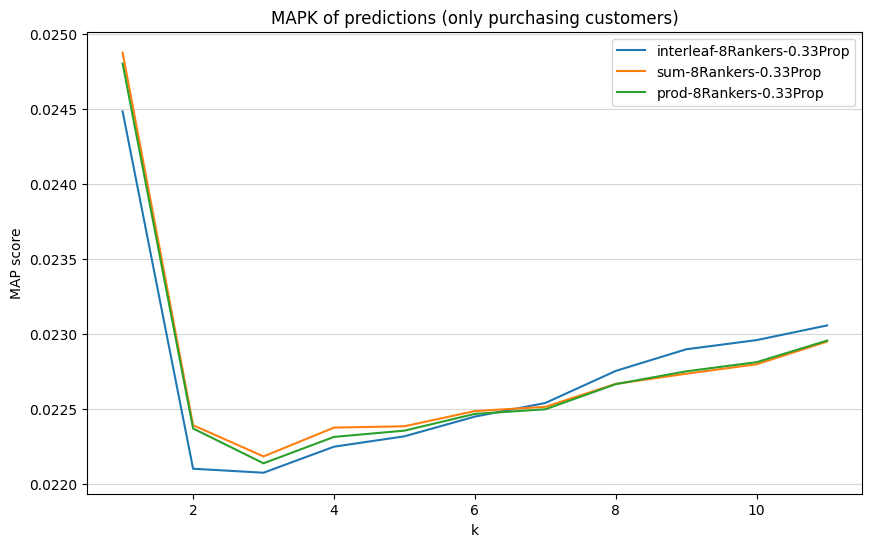

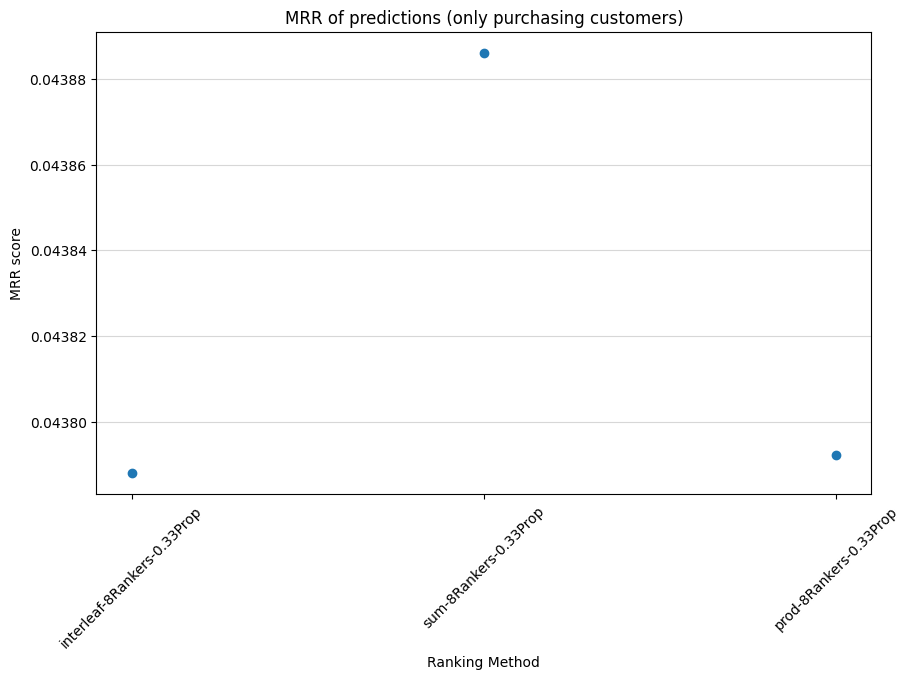

  Graphs for 0.66 sample proportion
Evaluation for interleaf-8Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011637204349231828
MAP@12 (only purchasing customers): 0.02314451412365053

MRR (all customers):                0.002209376613868676
MRR (only purchasing customers):    0.043940921470131414



Evaluation for sum-8Rankers-0.66Prop
####################

MAP@12 (all customers):             0.001155635805182813
MAP@12 (only purchasing customers): 0.02298372393590855

MRR (all customers):                0.0022073189132475733
MRR (only purchasing customers):    0.043899997138429285



Evaluation for prod-8Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011523083220753363
MAP@12 (only purchasing customers): 0.02291754568770903

MRR (all customers):                0.002199406217285488
MRR (only purchasing customers):    0.04374262643498991





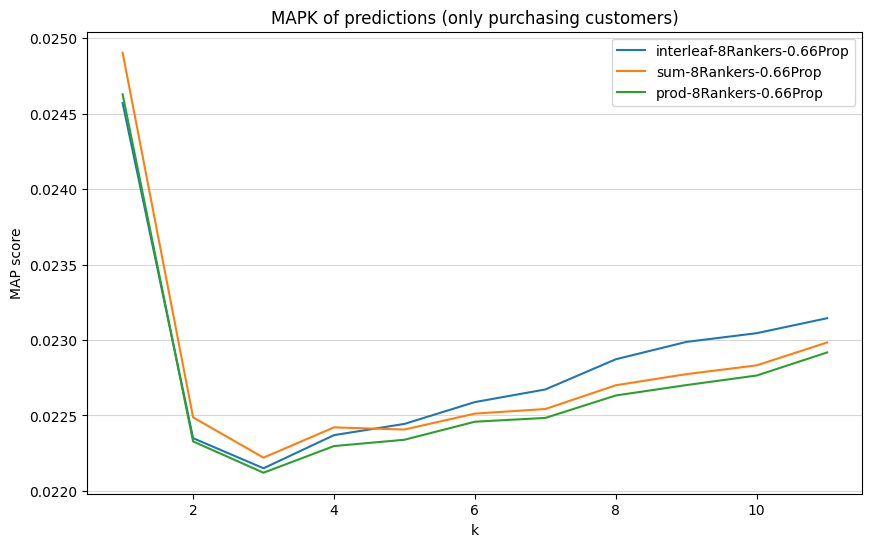

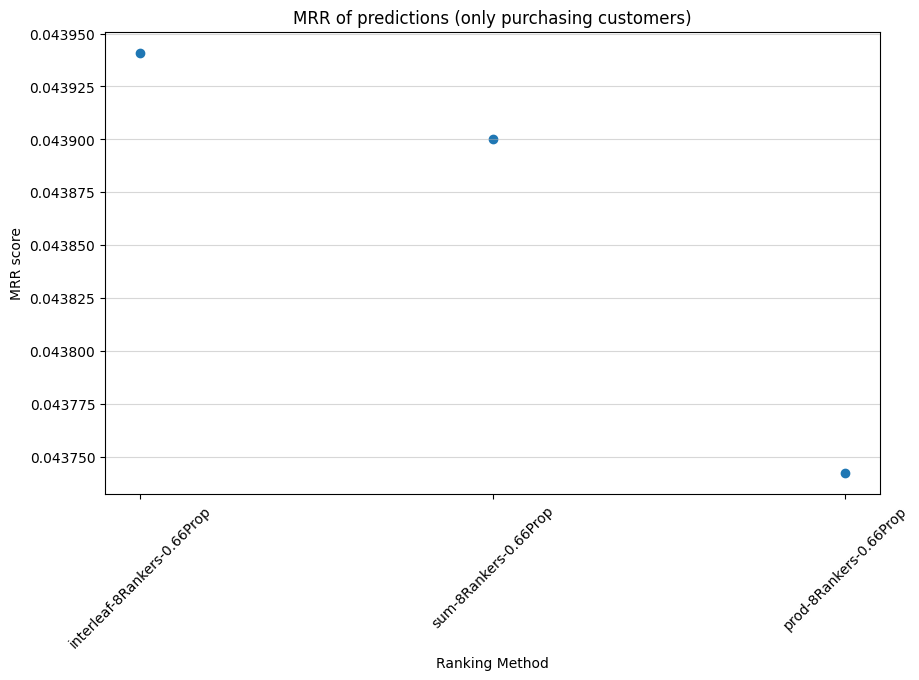

  Graphs for 1 sample proportion
Evaluation for interleaf-8Rankers-1Prop
####################

MAP@12 (all customers):             0.001165384303180154
MAP@12 (only purchasing customers): 0.02317760576767234

MRR (all customers):                0.002215041896979692
MRR (only purchasing customers):    0.044053594772964715



Evaluation for sum-8Rankers-1Prop
####################

MAP@12 (all customers):             0.0011518538357091525
MAP@12 (only purchasing customers): 0.022908506690192544

MRR (all customers):                0.002202907913268124
MRR (only purchasing customers):    0.04381226949503654



Evaluation for prod-8Rankers-1Prop
####################

MAP@12 (all customers):             0.0011550486133949582
MAP@12 (only purchasing customers): 0.022972045642549215

MRR (all customers):                0.0022067950813632244
MRR (only purchasing customers):    0.04388957897090219





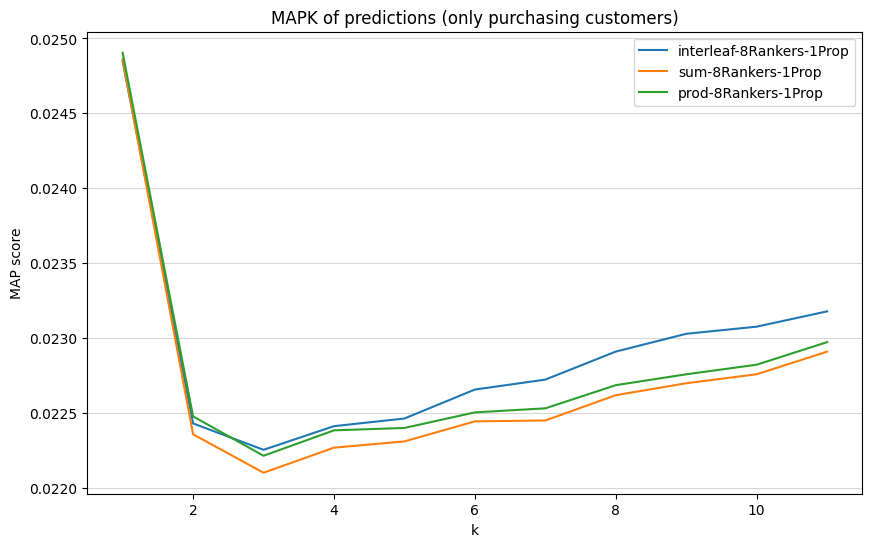

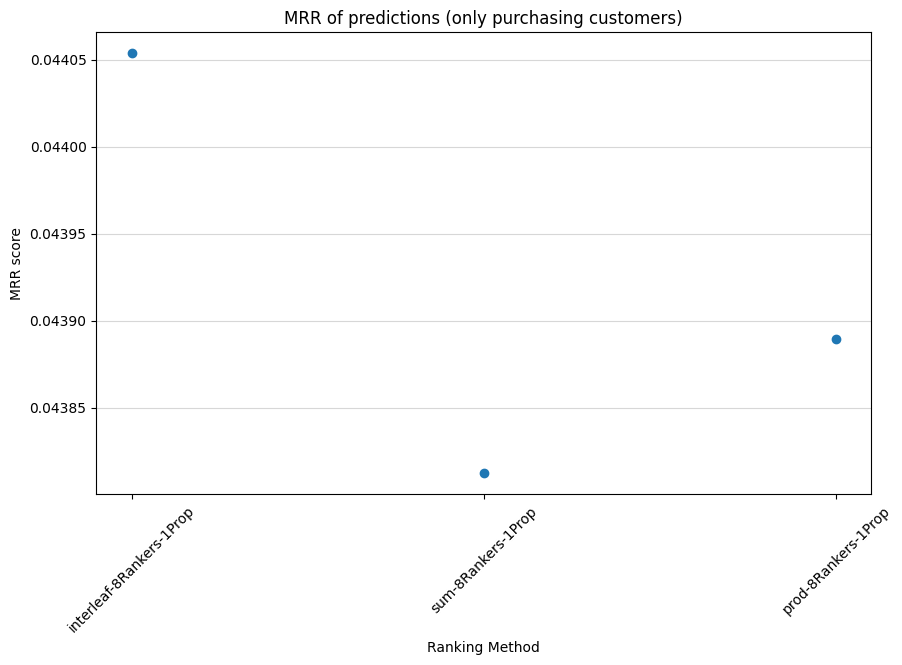

In [10]:
#comparing the different aggregation methods for each prop, nr_rankers combination
for nr in nr_rankers_range:
    print(f"Graphs for {nr} rankers")
    for sp in samples_proportion_range:
        print(f"  Graphs for {sp} sample proportion")
        preds_cols = [f"{agg}-{nr}Rankers-{sp}Prop" for agg in aggregation_methods]
        get_evaluation_plots(test, preds_cols, test_week_transactions, bestsellers_previous_week, graphs=["MAPK", "MRR"])       #all rankings are padded with bestsellers previous week

Interleaf appears, mostly, to be the best method for combining the rankings in this case. But which combination of rankers and proporition of samples is the optimal?

Graphs for interleaf aggregation method
Evaluation for interleaf-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011330430692613111
MAP@12 (only purchasing customers): 0.022534391020600907

MRR (all customers):                0.002162914050951781
MRR (only purchasing customers):    0.04301685636705359



Evaluation for interleaf-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011755672118718898
MAP@12 (only purchasing customers): 0.02338012732436499

MRR (all customers):                0.0022335886010648107
MRR (only purchasing customers):    0.044422458669965484



Evaluation for interleaf-1Rankers-1Prop
####################

MAP@12 (all customers):             0.00116729104668646
MAP@12 (only purchasing customers): 0.023215527806924638

MRR (all customers):                0.0022128578004210345
MRR (only purchasing customers):    0.04401015663083687



Evaluation for interleaf-4Rankers-0.33Prop
####################

MAP@12 

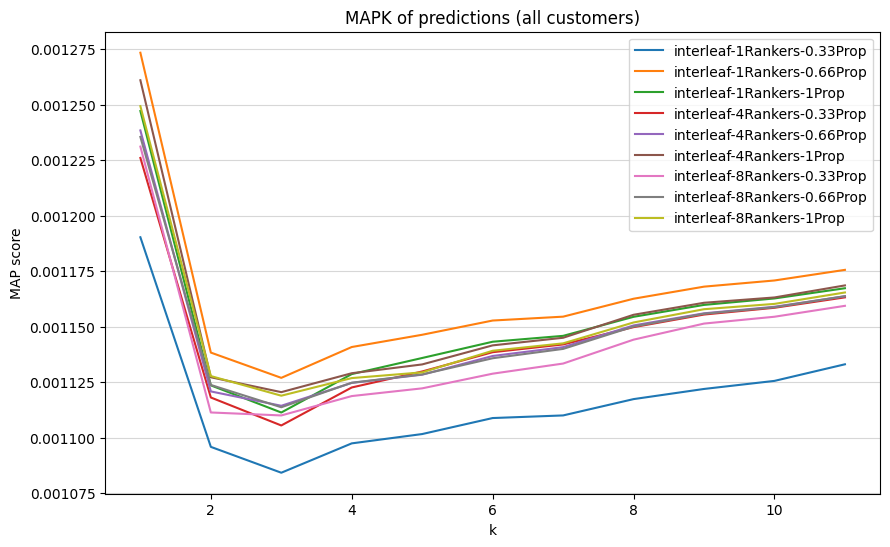

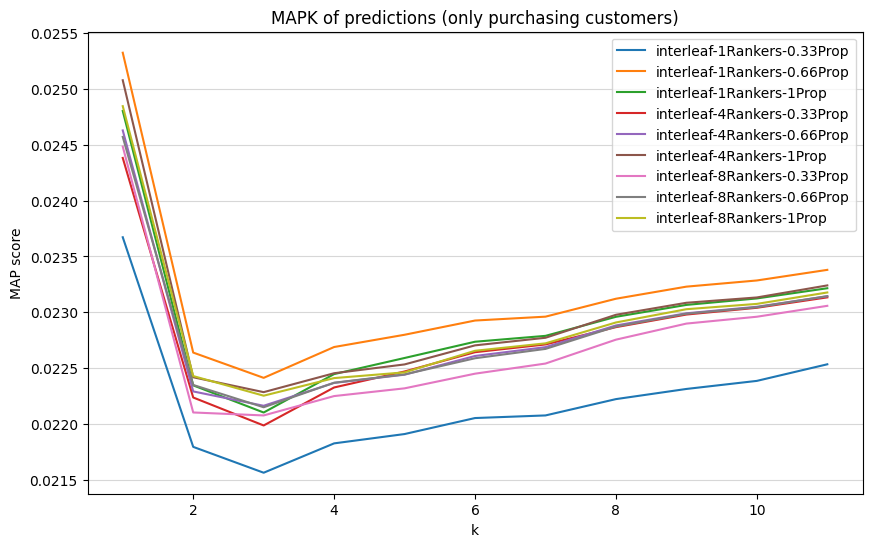

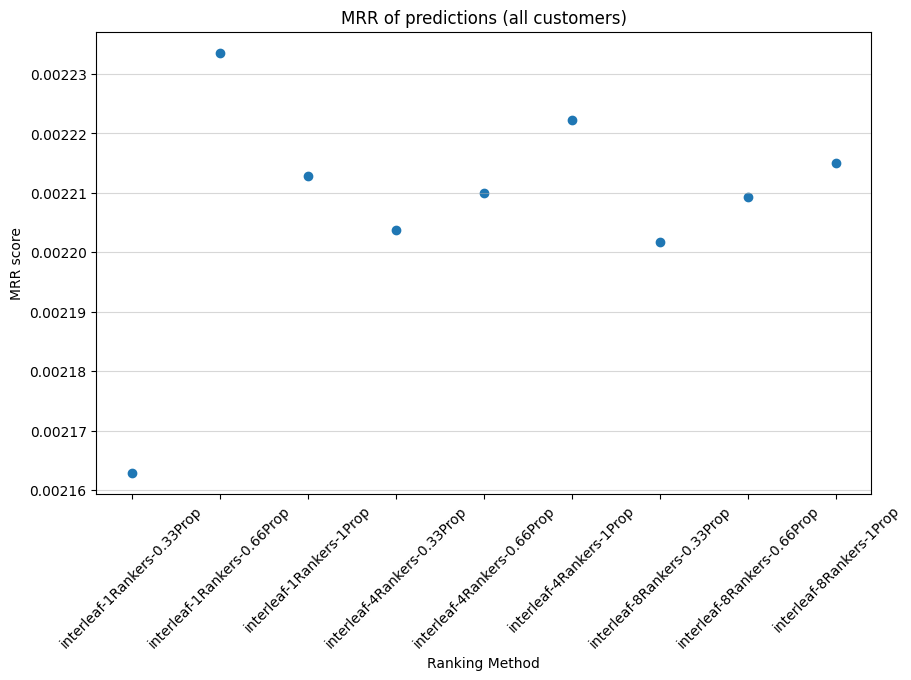

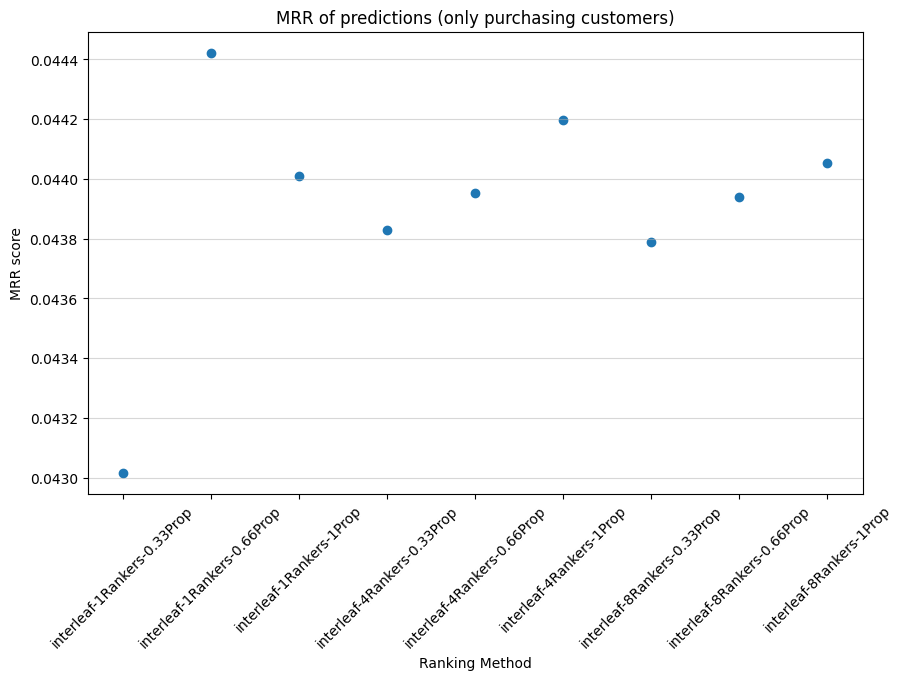

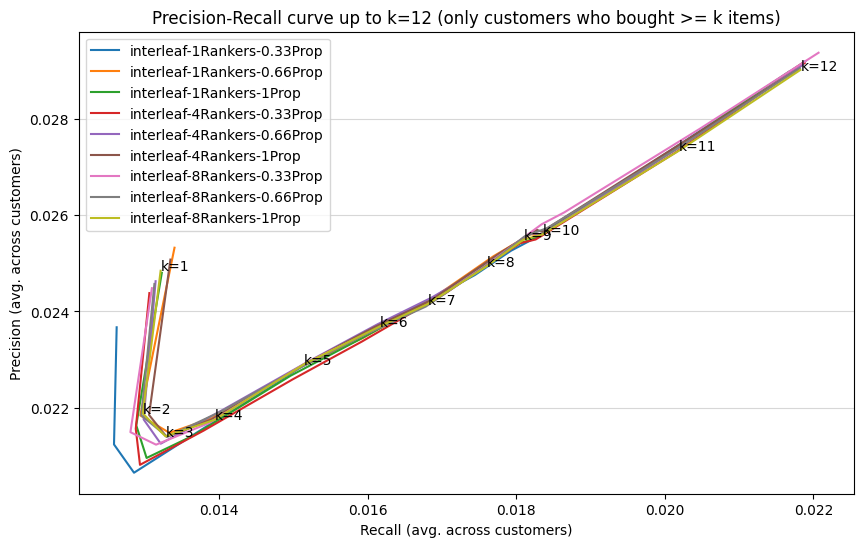

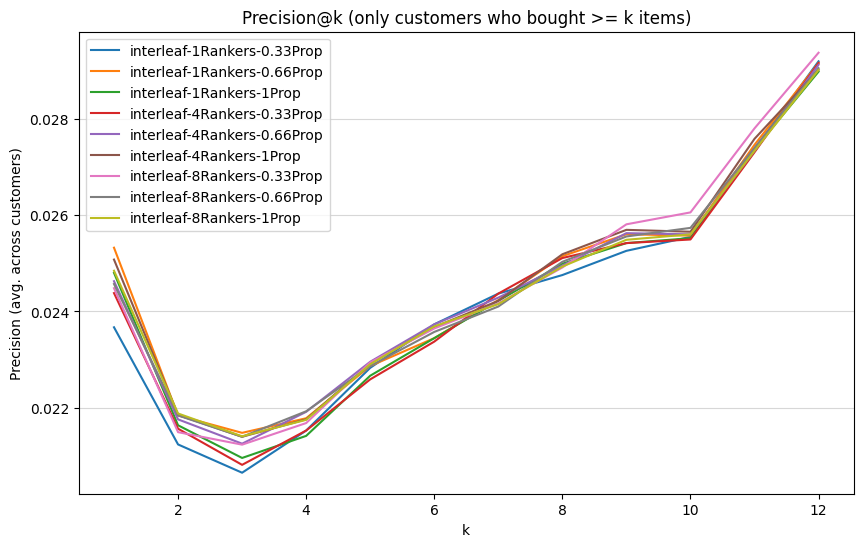

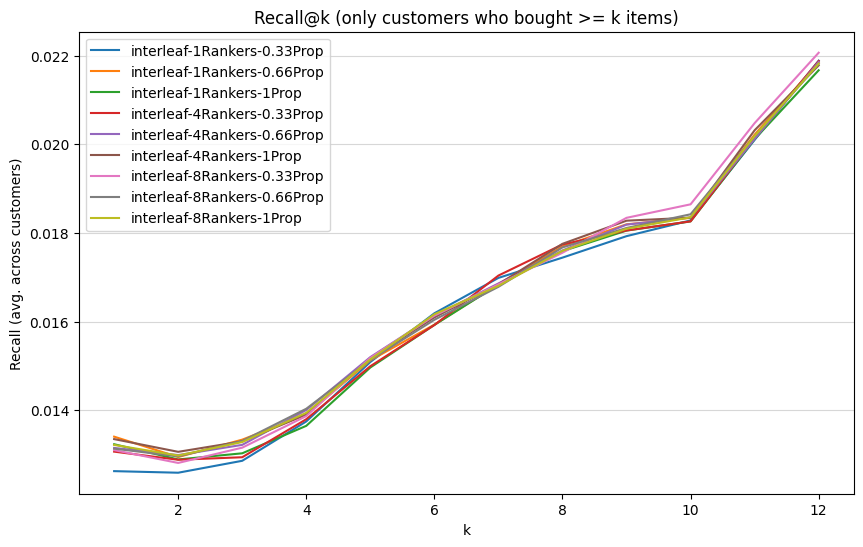

Graphs for sum aggregation method
Evaluation for sum-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011490361246794824
MAP@12 (only purchasing customers): 0.022852466982746084

MRR (all customers):                0.00219258635842697
MRR (only purchasing customers):    0.043606990491050594



Evaluation for sum-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.001169763589871583
MAP@12 (only purchasing customers): 0.023264702685144596

MRR (all customers):                0.002211468128755561
MRR (only purchasing customers):    0.043982518312797966



Evaluation for sum-1Rankers-1Prop
####################

MAP@12 (all customers):             0.0011720128154390473
MAP@12 (only purchasing customers): 0.023309436137743018

MRR (all customers):                0.0022187016996343778
MRR (only purchasing customers):    0.04412638231857204



Evaluation for sum-4Rankers-0.33Prop
####################

MAP@12 (all customers):             

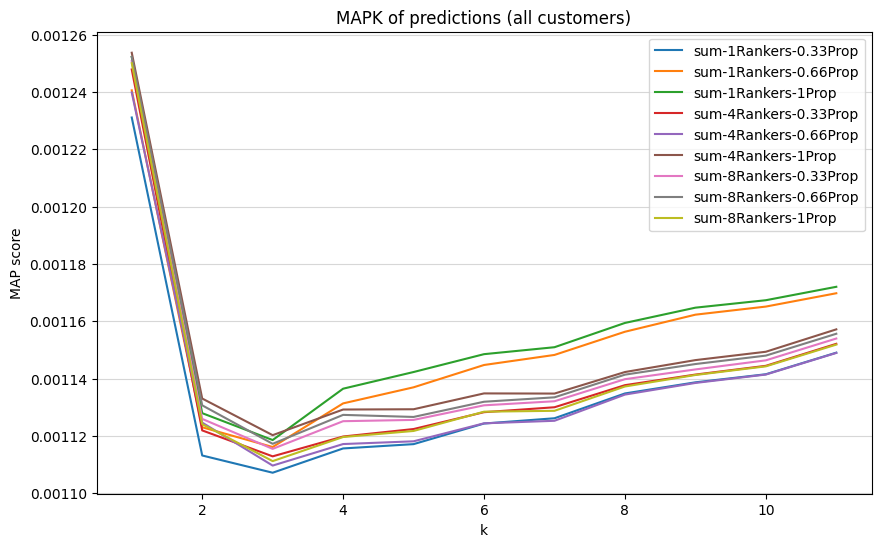

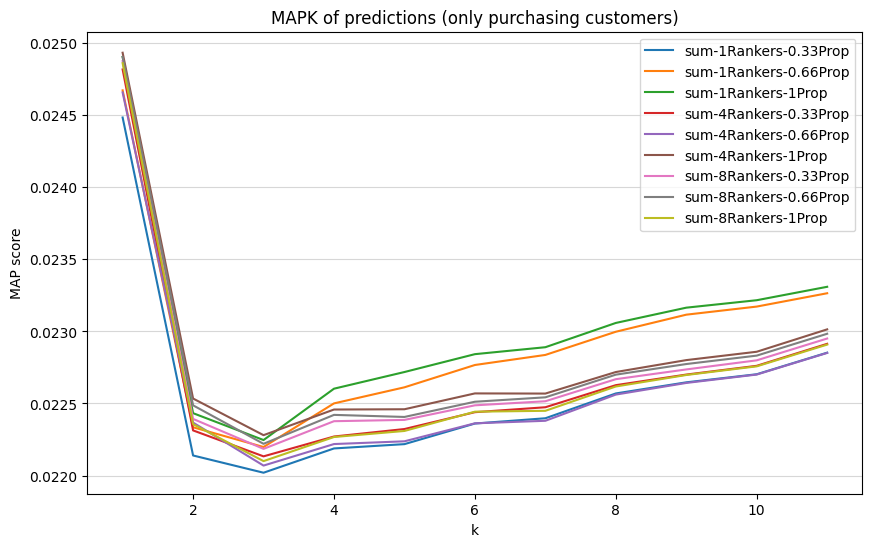

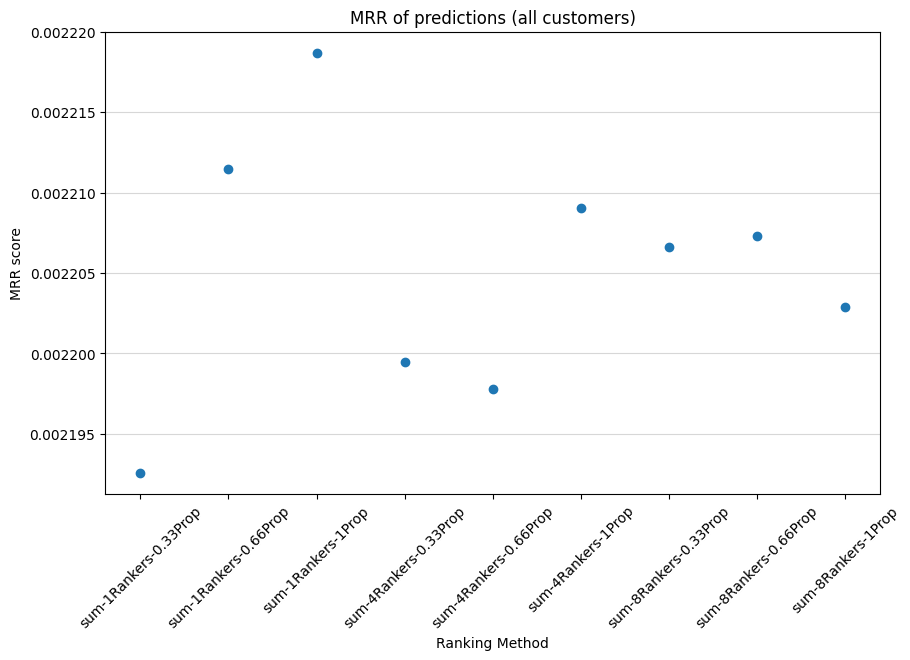

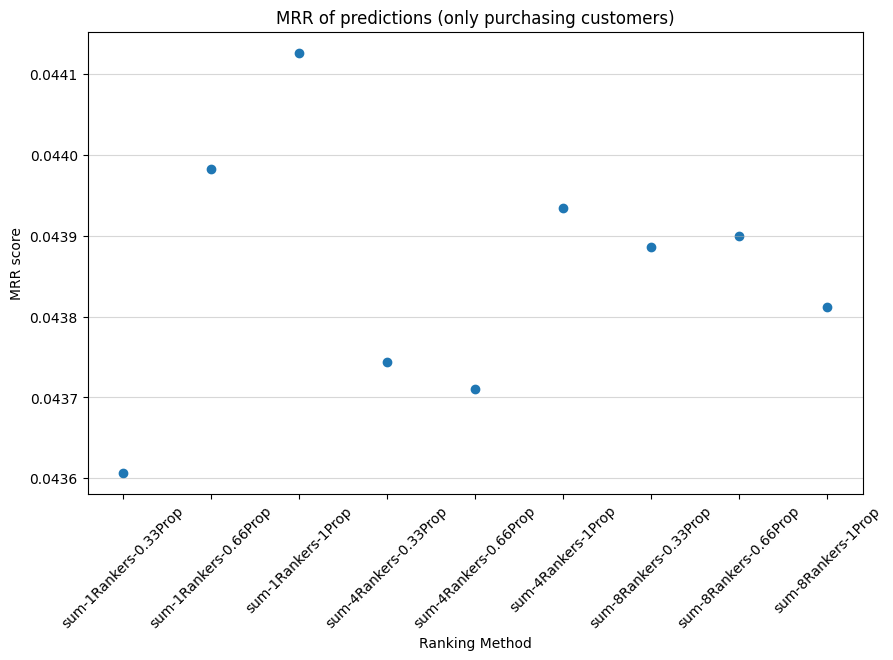

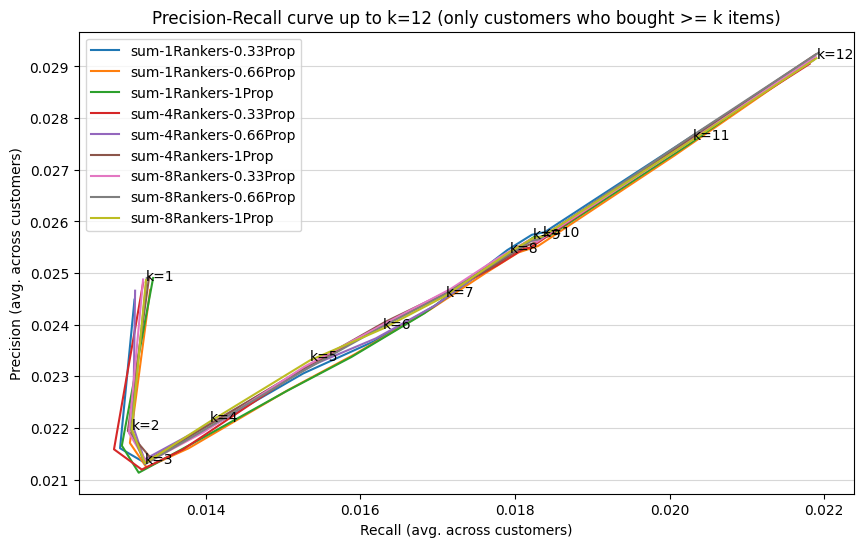

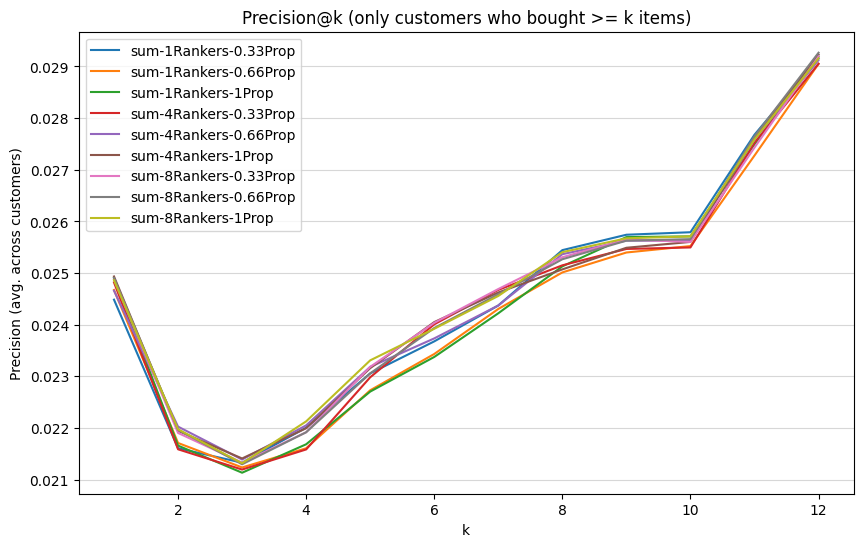

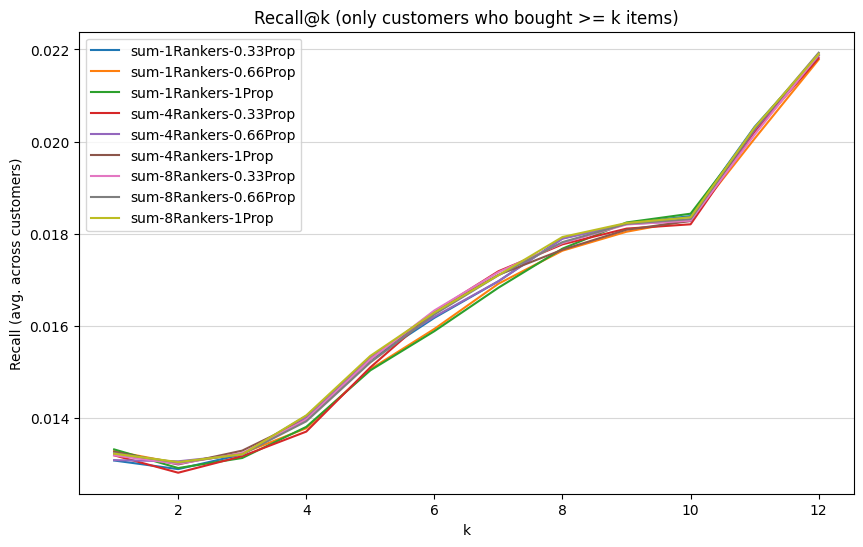

Graphs for prod aggregation method
Evaluation for prod-1Rankers-0.33Prop
####################

MAP@12 (all customers):             0.0011603764772451463
MAP@12 (only purchasing customers): 0.023078008222932784

MRR (all customers):                0.002195094293630723
MRR (only purchasing customers):    0.04365686925918299



Evaluation for prod-1Rankers-0.66Prop
####################

MAP@12 (all customers):             0.0011711336496210735
MAP@12 (only purchasing customers): 0.023291950953947586

MRR (all customers):                0.002225236714059447
MRR (only purchasing customers):    0.04425635316820249



Evaluation for prod-1Rankers-1Prop
####################

MAP@12 (all customers):             0.0011568086344114668
MAP@12 (only purchasing customers): 0.023007049609182477

MRR (all customers):                0.002201537515208272
MRR (only purchasing customers):    0.043785014497788544



Evaluation for prod-4Rankers-0.33Prop
####################

MAP@12 (all customers):        

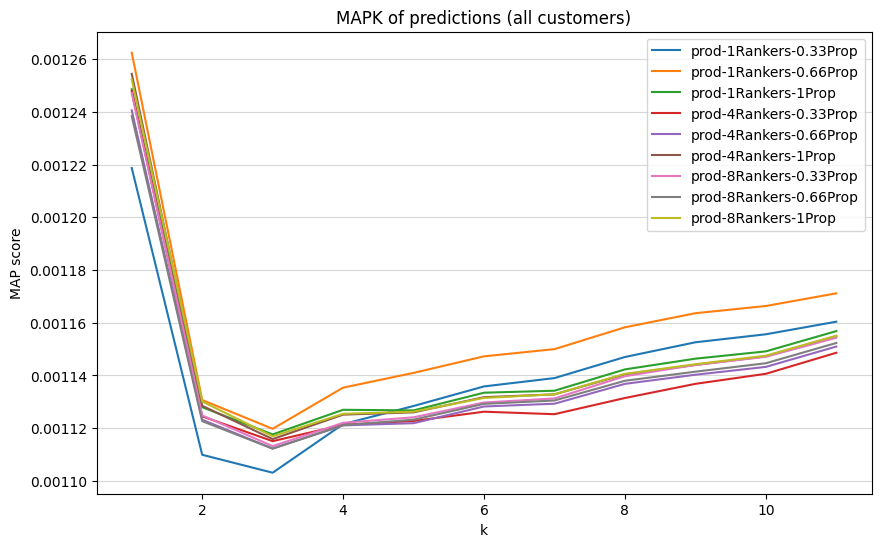

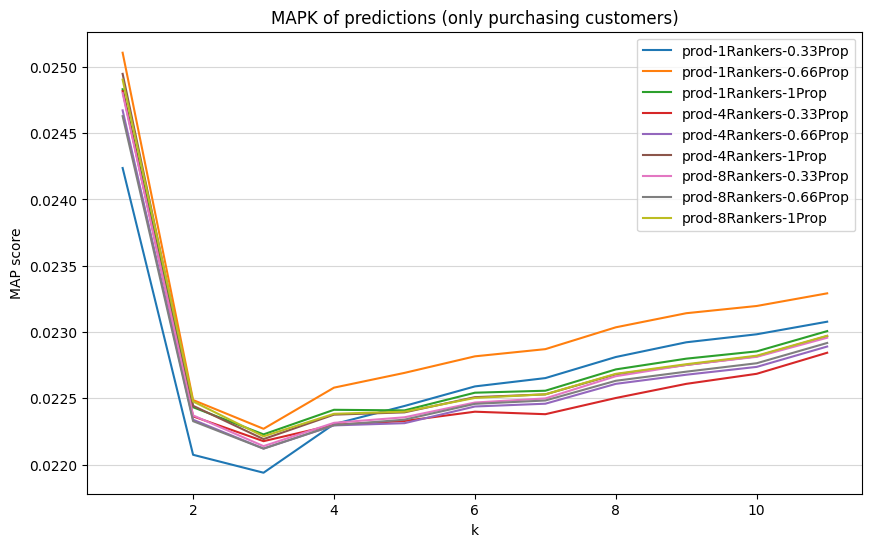

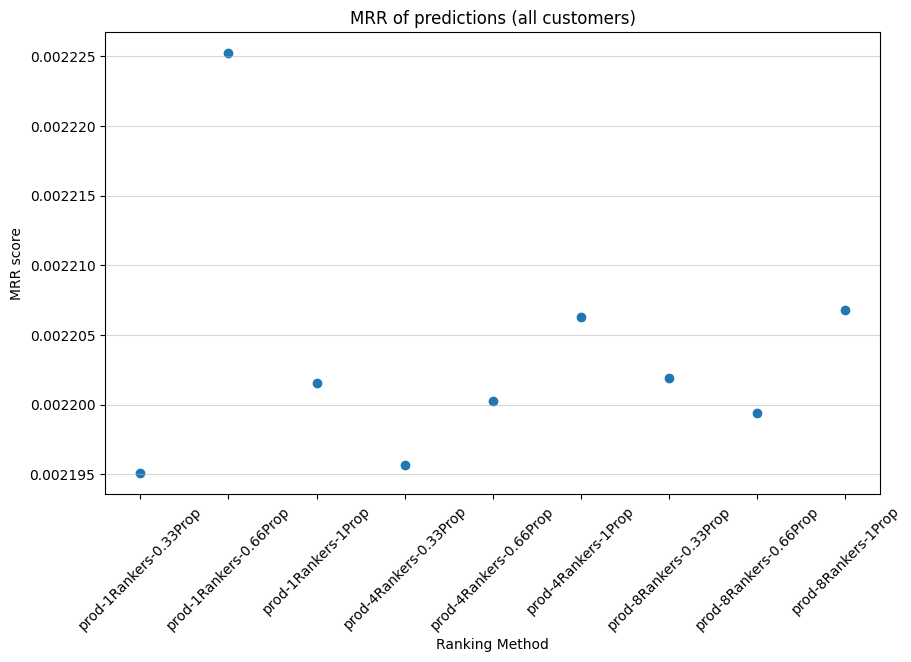

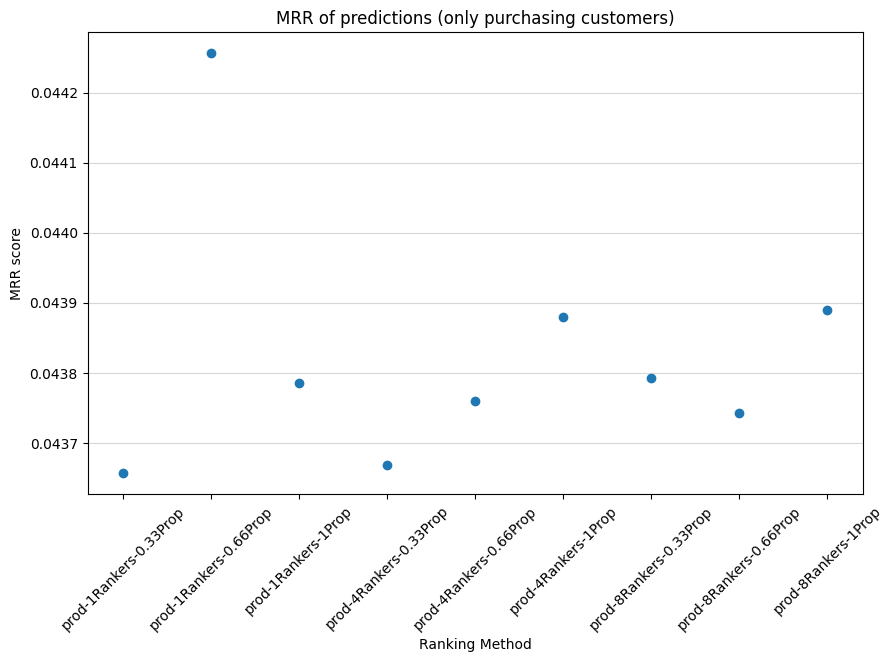

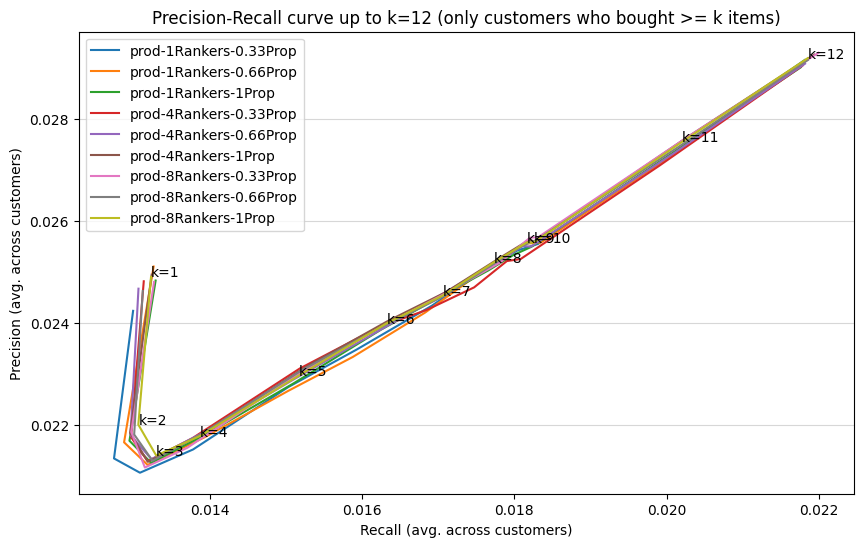

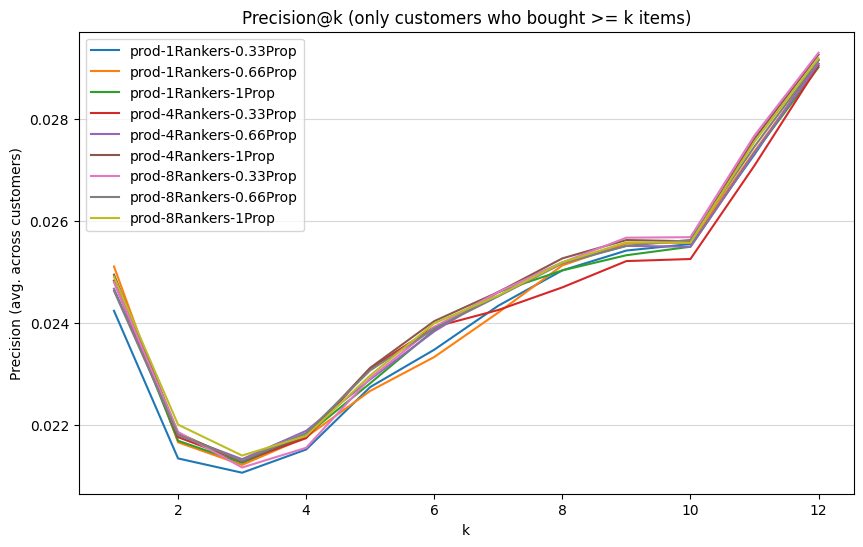

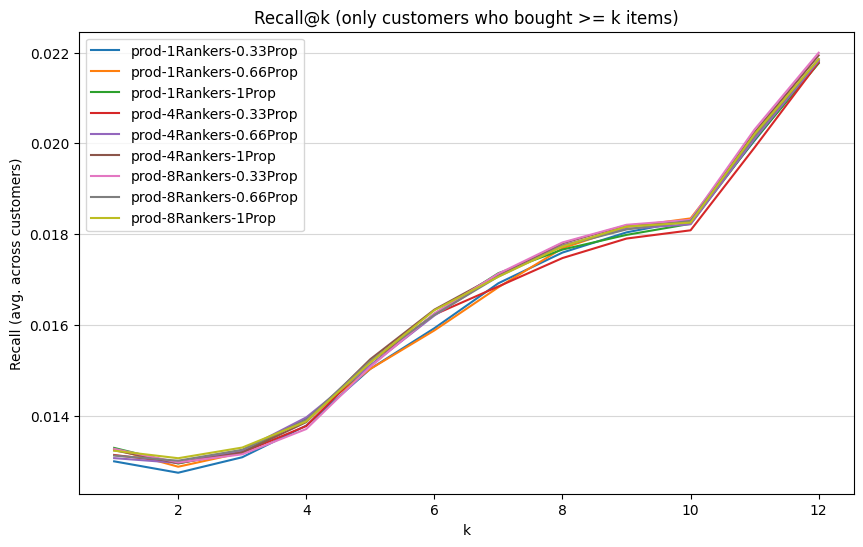

In [11]:
#comparing the different nr_rankers, prop combinations for each aggregation method
for agg in aggregation_methods:
    print(f"Graphs for {agg} aggregation method")
    preds_cols = [f"{agg}-{nr}Rankers-{sp}Prop" for nr in nr_rankers_range for sp in samples_proportion_range]
    get_evaluation_plots(test, preds_cols, test_week_transactions, bestsellers_previous_week)       #all rankings are padded with bestsellers previous week

Using bagging doesn't seem to give better results than just a single ranker. The best MAP@12 scores for each different rank aggregation method were attained using only a single ranker.